# **AI-POWERED DEMAND FORECASTING FOR PRODUCTS**

## Submitted by : Adityabaan Tripathy (IITRPRAI_24091312)

# ***1. Install & Import Libraries***

In [ ]:
!pip install xgboost shap --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import shap

# ***2. Loading of Dataset and Exploration of Columns***

In [ ]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print(df.head())
print("\nColumns:\n", df.columns)

Saving demand_forecasting_data.csv to demand_forecasting_data (2).csv
         Date Product_ID  Base_Sales Marketing_Campaign  Marketing_Effect  \
0  2019-01-01       P002          65       Social Media          1.634270   
1  2019-01-01       P004          94       Social Media          1.240566   
2  2019-01-01       P003         125              Radio          1.087600   
3  2019-01-01       P004         128                 TV          1.831657   
4  2019-01-01       P001          51              Radio          1.285161   

  Seasonal_Trend  Seasonal_Effect      Price  Discount  Competitor_Price  \
0         Spring              1.0  73.496059  0.078198         64.173418   
1         Summer              1.2  74.271862  0.182151         69.571391   
2         Summer              1.2  35.274616  0.102592         27.331268   
3         Winter              0.8  79.524248  0.196125         73.429502   
4           Fall              1.1  96.237402  0.079253         88.243871   

   Stock_A

# ***3. Data Cleaning & Preprocessing***

In [ ]:
df['Date'] = df['Date'].replace('########', np.nan)             #This line was written to avoid missing data problem if in case it was encountered based on earlier testings.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df['year'] = df['Date'].dt.year
df['week'] = df['Date'].dt.isocalendar().week
agg = df.groupby(['year', 'week', 'Product_ID', 'Base_Sales'])['Demand'].sum().reset_index()
agg['item_code'] = agg['Product_ID'].astype('category').cat.codes
agg['store_code'] = agg['Base_Sales'].astype('category').cat.codes
print(agg.head())

   year  week Product_ID  Base_Sales  Demand  item_code  store_code
0  2019     1       P001          51   26917          0           1
1  2019     1       P001          52   22528          0           2
2  2019     1       P001          56   24277          0           6
3  2019     1       P001          58   72315          0           8
4  2019     1       P001          60   31860          0          10


# ***4. Feature Engineering (Lag Features & Seasonality)***

In [ ]:
agg = agg.sort_values(by=['item_code', 'store_code', 'year', 'week'])
agg['lag_1'] = agg.groupby(['item_code', 'store_code'])['Demand'].shift(1)
agg['lag_2'] = agg.groupby(['item_code', 'store_code'])['Demand'].shift(2)
agg[['lag_1', 'lag_2']] = agg[['lag_1', 'lag_2']].fillna(0)
agg['quarter'] = ((agg['week'] - 1) // 13) + 1
print(agg.head())

      year  week Product_ID  Base_Sales  Demand  item_code  store_code  \
760   2019     5       P001          50   23256          0           0   
1347  2019     8       P001          50    6876          0           0   
1708  2019    10       P001          50    3907          0           0   
2307  2019    13       P001          50   42643          0           0   
3454  2019    19       P001          50   17779          0           0   

        lag_1    lag_2  quarter  
760       0.0      0.0        1  
1347  23256.0      0.0        1  
1708   6876.0  23256.0        1  
2307   3907.0   6876.0        1  
3454  42643.0   3907.0        2  


# ***5. Prepare Features and Target Variable***

In [ ]:
features = ['year', 'week', 'item_code', 'store_code', 'lag_1', 'lag_2', 'quarter']
X = agg[features]
y = agg['Demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ***6. Model Training: Random Forest, Gradient Boosting, and XGBoost***

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ***7. Evaluation and Comparison of Models***

In [ ]:
def print_metrics(true, pred, model_name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return rmse, mae

rf_rmse, rf_mae = print_metrics(y_test, rf_pred, "Random Forest")
gb_rmse, gb_mae = print_metrics(y_test, gb_pred, "Gradient Boosting")
xgb_rmse, xgb_mae = print_metrics(y_test, xgb_pred, "XGBoost")

# Summary Table
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'RMSE': [rf_rmse, gb_rmse, xgb_rmse],
    'MAE': [rf_mae, gb_mae, xgb_mae]
})
print("\nModel Comparison:\n", results_df)

Random Forest - RMSE: 44290.27, MAE: 32506.80
Gradient Boosting - RMSE: 43185.97, MAE: 31442.08
XGBoost - RMSE: 43570.65, MAE: 31748.87

Model Comparison:
                Model          RMSE           MAE
0      Random Forest  44290.272094  32506.802748
1  Gradient Boosting  43185.970997  31442.083345
2            XGBoost  43570.649938  31748.873047


# ***8. Feature Importance Plot (Using Random Forest)***

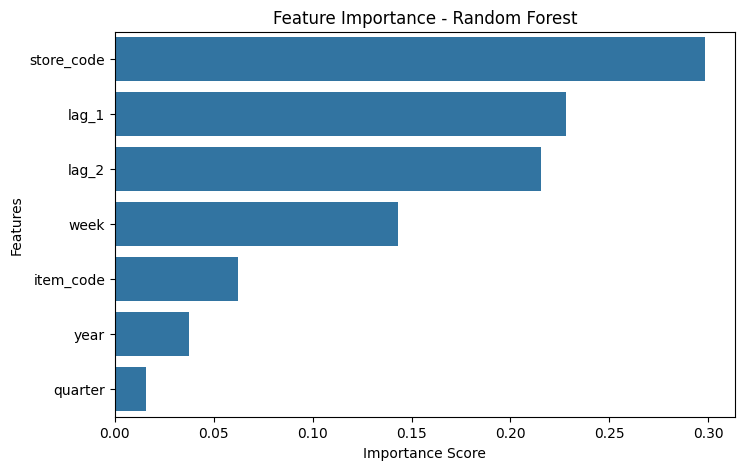

In [ ]:
importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=feat_importance, y=feat_importance.index)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


# ***9. SHAP Explainability for XGBoost***

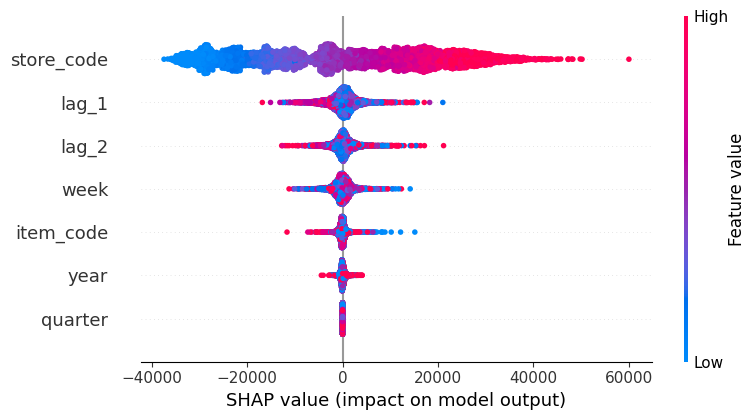

In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)


# ***10. Visualization of Predicted vs Actual Sales for Top Products***

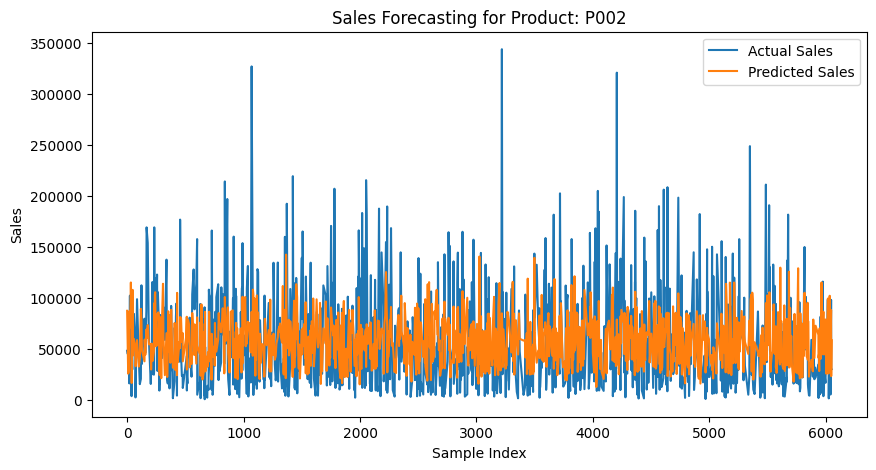

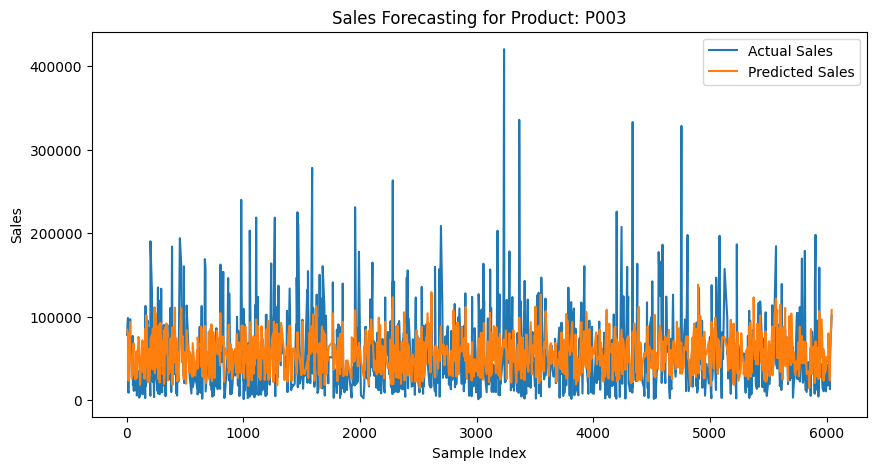

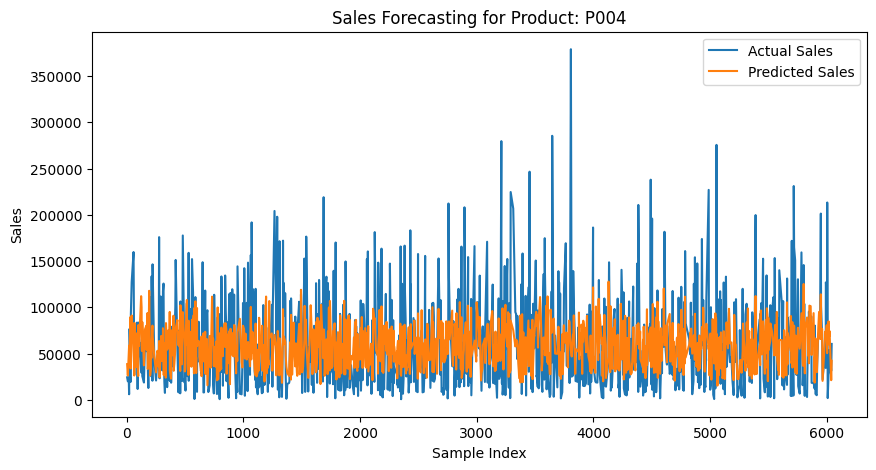

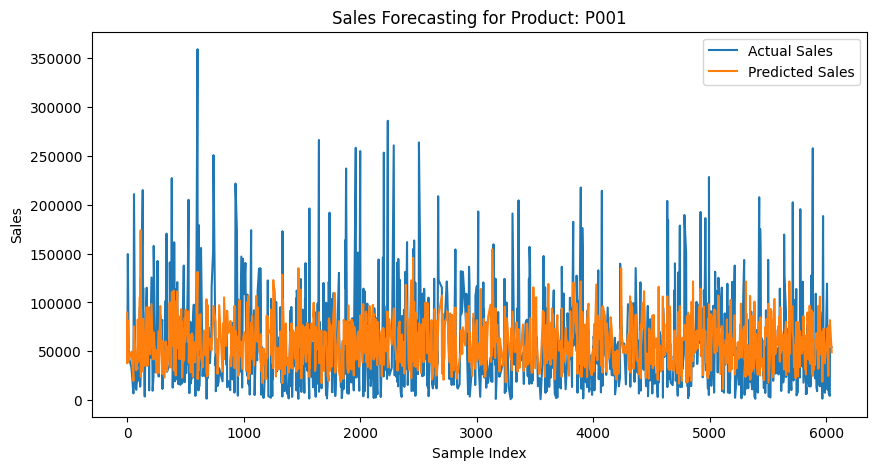

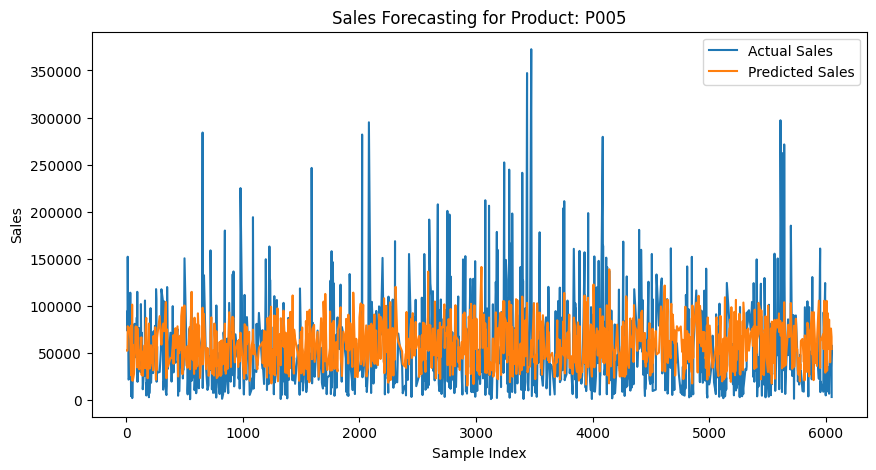

In [ ]:
code_to_item = dict(zip(agg['item_code'], agg['Product_ID']))
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_test['item_name'] = X_test['item_code'].map(code_to_item)
X_test['actual_sales'] = y_test
X_test['predicted_sales'] = rf_pred
top_products = X_test['item_name'].value_counts().index[:5]
for product in top_products:
    subset = X_test[X_test['item_name'] == product]
    plt.figure(figsize=(10, 5))
    plt.plot(subset.index, subset['actual_sales'], label='Actual Sales')
    plt.plot(subset.index, subset['predicted_sales'], label='Predicted Sales')
    plt.title(f'Sales Forecasting for Product: {product}')
    plt.xlabel('Sample Index')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# ***11. Seasonality Exploration (Sales by Quarter)***

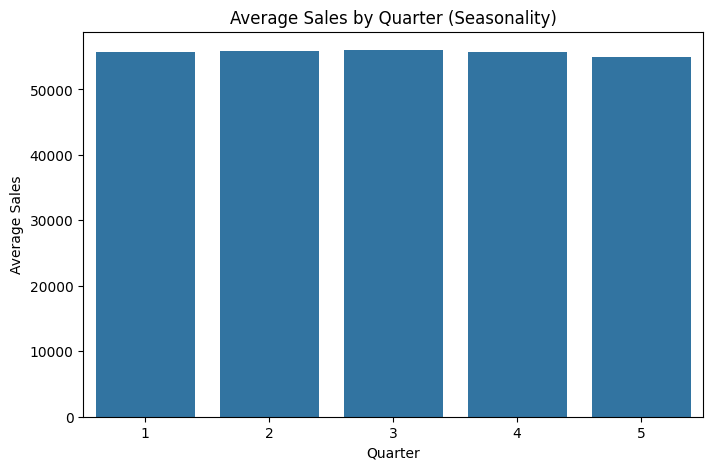

In [ ]:
seasonality = agg.groupby('quarter')['Demand'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='quarter', y='Demand', data=seasonality)
plt.title('Average Sales by Quarter (Seasonality)')
plt.xlabel('Quarter')
plt.ylabel('Average Sales')
plt.show()